In [50]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import scipy.linalg as la
import time

### Task 21
LU and cholesky decompositions

In [51]:
n = 50 # 4000

def frobenius(M):
    return np.sqrt(np.sum(np.power(M,2)))

def compute_lu_error(M, P, L, U):
    P_Inv = la.inv(P)
    L_Inv = la.inv(L)
    U_Inv = la.inv(U)

    M_Inv =  np.dot(np.dot(U_Inv, L_Inv), P_Inv)

    return frobenius(np.dot(M, M_Inv) - np.identity(n))

def compute_cholesky_error(M, L):
    L_Inv = la.inv(L)
    LT_Inv = la.inv(np.transpose(L))

    M_Inv = np.dot(LT_Inv, L_Inv)

    return frobenius(np.dot(M, M_Inv) - np.identity(n))

init tridiagonal matrix A

In [52]:
A = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        if i == j:
            A[i][j] = 2
        if i == j + 1 or i + 1 == j:
            A[i][j] = -1
            A[i][j] = -1

Hermitian matrix with $a_{ij} = a_{ji}$

In [53]:
B = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        rand = random.rand(1)
        B[i][j] = rand
        B[j][i] = rand

Compute LU decomposition

In [54]:
start = time.time()
(P, L, U) = la.lu(A)
end = time.time()

print("Time for LU decomposition of A: ", end - start)
print("LU error for A:", compute_lu_error(A, P, L, U))

start = time.time()
(P, L, U) = la.lu(B)
end = time.time()

print("Time for LU decomposition of A: ", end - start)
print("LU error for B:", compute_lu_error(B, P, L, U))

Time for LU decomposition of A:  0.08277034759521484
LU error for A: 1.1991552630392586e-13
Time for LU decomposition of A:  0.024576902389526367
LU error for B: 2.0424429325817479e-13


In [55]:
L = la.cholesky(A, lower=True, overwrite_a=False, check_finite=True)
print("Cholesky error for A: " , compute_cholesky_error(A, L))

B = B @ np.transpose(B)
L = la.cholesky(B, lower=True, overwrite_a=False, check_finite=False)
print("Cholesky error for B: " , compute_cholesky_error(B, L))


Cholesky error for A:  1.6317663868652215e-13
Cholesky error for B:  4.3690502855100216e-10


### Task 23
Solver using recursive blocking

In [56]:
def recursive_blocking(L, Y):
    n = Y.shape[0]

    L11 = L[0 : n//2, 0 : n//2]
    L21 = L[n//2 :, 0 : n//2]
    L22 = L[n//2 :, n//2 :]

    if n == 2:
        # step 1
        Y[0:n//2, :] = Y[0:n//2, :] / L11
        # step 2
        r1 = Y[n//2:, :] - np.dot(L21, Y[0 : n//2, :])
        # step 3
        Y[n//2:, :] = r1/L22
    else:
        # step 1
        Y[0:n//2, :] = recursive_blocking(L11, Y[0:n//2, :])
        # step 2
        r1 = Y[n//2:, :] - np.dot(L21,Y[0:n//2, :])
        # step 3
        Y[n//2:, :] = recursive_blocking(L22, r1)

    return Y

Initialize L and Y

size  4 :  0.08  sec
size  8 :  0.0  sec
size  16 :  0.0  sec
size  32 :  0.0  sec
size  64 :  0.03  sec
size  128 :  0.01  sec
size  256 :  0.03  sec
size  512 :  0.06  sec
size  1024 :  0.09  sec
size  2048 :  0.4  sec
size  4096 :  2.61  sec
size  8192 :  18.56  sec


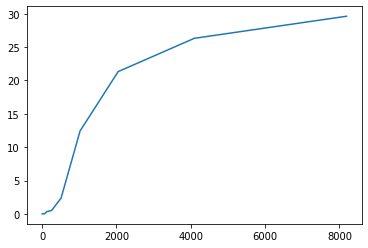

In [57]:
N = [2**i for i in range(2, 14)]
FLOPS = np.zeros(len(N))

for k in range(0, len(N)):

    n = N[k]
    Y = np.zeros((n,n))

    for i in range(0, n):
        for j in range(0, n):
            Y[i][j] = random.rand(1)

    T = np.copy(Y)
    P, L, U = la.lu(T)

    start = time.time()
    X = recursive_blocking(L, Y)
    end = time.time()

    print("size ", n, ": ", round(end - start, 2), " sec")

    flops = n**3 / (end-start) * 1e-9
    FLOPS[k] = flops

plt.plot(N, FLOPS)
plt.show()

### Task 24
Cholesky factorization for tridiagonal block matrices

Compute blockwise cholesky factorization

In [58]:
def factorization(A):
    L = np.copy(A)
    L[0] = la.cholesky(A[0], lower=True)
    # always iterative: off diagonal element and diagonal element
    for i in range(1,len(A),2):
        # step 2: off diagonal element Li-1,i = Ai-1,i*(Li-1,i-1^T)^-1, eg L21 = A21*(L11^T)^-1
        L[i] = np.dot(A[i], np.linalg.inv(L[i-1].transpose()))
        # step 3: diagonal elements Aii = Li,i-1Li,i-1^T * Lii*Lii^T, eg L22*L22^T = A22 - L21*L21^T
        L[i+1] = la.cholesky(A[i+1] - np.dot(L[i], L[i].transpose()), lower=True)



def chol_fact(A):
    L = np.copy(A)
    L[0] = la.cholesky(A[0], lower=True)
    for i in range(1,len(A),2):
        L[i] = np.dot(A[i], la.inv(np.transpose(L[i-1])))
        L[i+1] = la.cholesky(A[i+1] - np.dot(L[i], np.transpose(L[i])))
    return L

Compute Matrix A

In [59]:
def A(m, n):
    Aii = np.identity(m) * 4 #
    u = np.diagflat(np.linspace(-1, -1, m - 1) , 1)
    l = np.diagflat(np.linspace(-1, -1, m - 1) , -1)
    Aii = Aii + u + l

    Aij = -np.identity(m)

    # assemble matrix in list
    A = []
    for i in range(0, n):
        for j in range(0, n):
            if i == j:
                A.append(Aii)
            elif j == i + 1:
                A.append(Aij)
    return A

In [60]:
n = 3 # outter matrix size
m = 4 # matrix block size

A = A(m, n)
L = chol_fact(A)

print(L)


[[[ 2.          0.          0.          0.        ]
  [-0.5         1.93649167  0.          0.        ]
  [ 0.         -0.51639778  1.93218357  0.        ]
  [ 0.          0.         -0.51754917  1.93187548]]

 [[-0.5        -0.12909944 -0.03450328 -0.00924342]
  [ 0.         -0.51639778 -0.13801311 -0.03697369]
  [ 0.          0.         -0.51754917 -0.13865135]
  [ 0.          0.          0.         -0.51763171]]

 [[ 1.93185336 -0.55478866 -0.00990694 -0.00247674]
  [ 0.          1.84529895 -0.58638265 -0.01111626]
  [ 0.          0.          1.83547702 -0.58748393]
  [ 0.          0.          0.          1.84032343]]

 [[-0.51763763  0.          0.          0.        ]
  [-0.15562762 -0.54191761  0.          0.        ]
  [-0.05251253 -0.17312725 -0.5448175   0.        ]
  [-0.0184002  -0.05854056 -0.17392134 -0.54338275]]

 [[ 1.93185178 -0.55933831 -0.01407068 -0.00493031]
  [ 0.          1.8355506  -0.60464875 -0.02034564]
  [ 0.          0.          1.81786831 -0.61513143]
  [ 

We need to solve $LL^{T}U = h^{2}f$. $L$ is a lower triangular matrix which we can solve using forward substitution.
$L_{T}$ is a upper triangular matrix, which we can solve using backward substitution
Question: what is $h^{2}$, U is a matrix, how do you apply back and forward substitution with a matrix.